
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Anual Weather Types (AWT) following the methodology explained in Anderson et al. (2019)

inputs required: 
  * Averaged monthly Sea Surface Temperature (SST) anomalies. Extracted from the Extended Reconstructed Sea Surface Temperature v4 (ERSSTv4; Huang et al., (2015)). Rectangular region from 120°E to 280°E and 5°N to 5°S 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.pca import PCA_LatitudeAverage
from teslakit.kma import KMA_simple
from teslakit.statistical import CopulaSimulation
from teslakit.alr import ALR_WRP

from teslakit.plotting.awt import Plot_AWTs_EOFs, Plot_AWTs, Plot_AWTs_Dates, Plot_AWTs_Validation
from teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

SST = db.Load_SST()  # SST Predictor
var_name = 'SST'

# SST Predictor PCA parameters
pca_year_ini = 1880
pca_year_end = 2016
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6
repres = 0.95

# ALR parameters
alr_markov_order = 2

# PCs copula generation parameters (PCs 1, 2, 3)
num_PCs_rnd = 1000
kernels = ['KDE', 'KDE', 'KDE']

# Simulation
num_sims = 10
y1_sim = 2000
y2_sim = 3000



## SST  - Principal Components Analysis

In [4]:
# --------------------------------------
# Principal Components Analysis SST data

# load SST PCs
SST_PCA = db.Load_SST_PCA()



## SST - KMeans Classification --> Annual Weather Types

In [5]:
# --------------------------------------
# KMA Classification 

# load SST AWTs
SST_AWTs = db.Load_SST_KMA()


In [6]:
# --------------------------------------
# PCs123 random generation with Copulas

vari = SST_AWTs.variance.values[:]

# store PCs used for fitting and simulated
PCs_fit, PCs_rnd = db.Load_SST_PCs_fit_rnd()



## Autoregressive Logistic Regression

In [7]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# bmus series
bmus_fit = xr.Dataset(
    {
        'bmus':(('time',), SST_AWTs.bmus.values[:] + 1),
    },
    coords = {'time': SST_AWTs.time.values[:]}
)


# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : True,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.SST.alrw)
ALRW.SetFitData(num_clusters, bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)

ALRW.Report_Fit()


Fitting autoregressive logistic model ...
Optimization done in 0.65 seconds

warning - statsmodels MNLogit could not provide p-values


In [8]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates (annual array)
dates_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]

# launch simulation
ALR_sim = ALRW.Simulate(num_sims, dates_sim)

# store simulated Annual Weather Types
SST_AWTs_sim = ALR_sim.evbmus_sims.to_dataset()
print(SST_AWTs_sim)

sys.exit()
#db.Save_SST_AWT_sim(SST_AWTs_sim)


ALR model fit   : 1880-06-01 --- 2016-06-01
ALR model sim   : 1999-06-01 --- 3000-06-01

Launching 10 simulations...

Sim. Num. 010: 100%|██████████| 1000/1000 [00:00<00:00, 1606.78it/s]

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 1002)
Coordinates:
  * time         (time) object 1999-06-01 2000-06-01 ... 2999-06-01 3000-06-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2


SystemExit: 

PerpetualYear bmus comparison skipped.
timedelta (days): Hist - 365, Sim - 366)


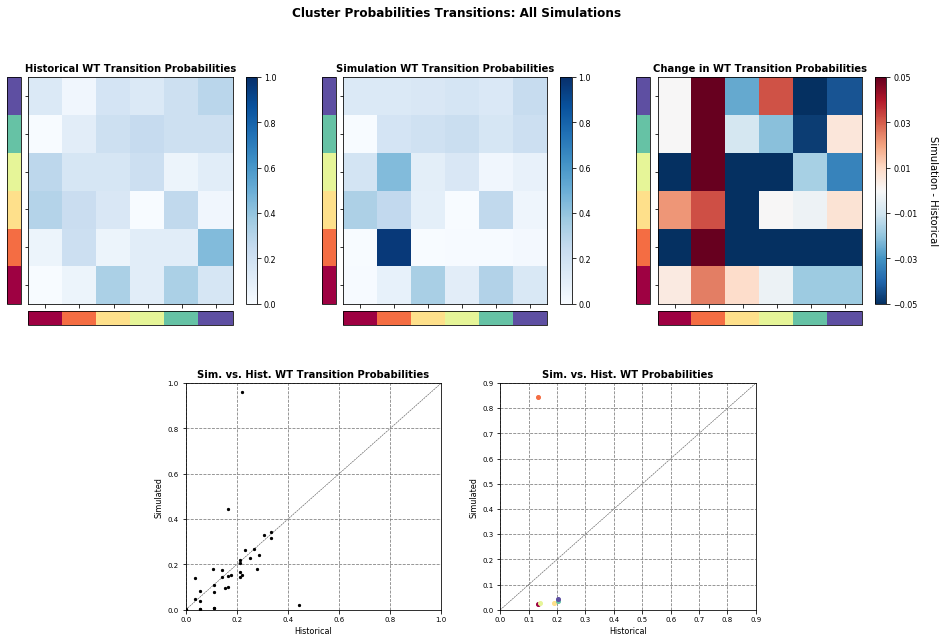

In [9]:
# show simulation report
ALRW.Report_Sim();


In [ ]:
# --------------------------------------
# PCs generation

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : dates_sim}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
#db.Save_SST_PCs_sim(SST_PCs_sim)
